# Usage Example

## 1. Installation

First, we need to install the `clustermole_py` package. Second, we need to install `scanpy` and some of its supporting packages `igraph` and `leidenalg` to go through the examples. You can install them all using pip:

In [10]:
!pip install scanpy igraph leidenalg git+https://github.com/nmlakra/clustermole-py.git --quiet


---
## 2. Import Libraries

Next, we import the necessary libraries. We'll need `clustermole_py`, `scanpy` and potentially `pandas` for data manipulation.



In [11]:
import scanpy as sc
import pandas as pd
from clustermolepy.enrichr import Enrichr
import clustermolepy.gsva as gsva

import warnings
warnings.filterwarnings("ignore")

---
## 3\. Prepare Cluster Data using Scanpy

In this example, we'll use the `pbmc3k` dataset from Scanpy and perform Leiden clustering to define cell clusters. We'll then identify marker genes for each cluster using Scanpy's differential expression functionality. These marker genes will be used as input for `clustermole_py`.

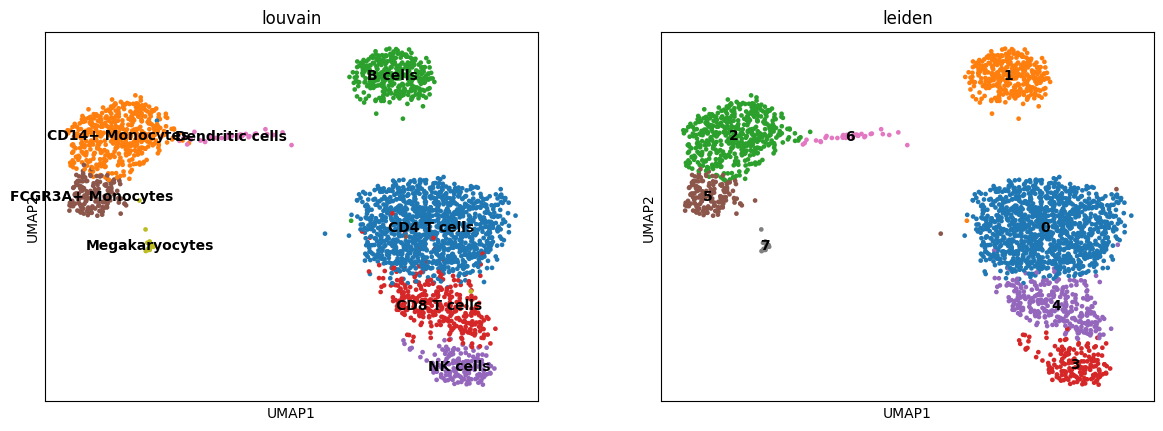

In [12]:
adata_raw = sc.datasets.pbmc3k()
adata = sc.datasets.pbmc3k_processed()
adata.layers['counts'] = adata_raw[adata.obs.index, adata.var.index].X


sc.tl.leiden(adata, flavor='igraph', n_iterations=2, resolution=0.8)
sc.pl.umap(adata, color=['louvain', 'leiden'], legend_loc='on data')

---
### 3.1. Identify Cluster Marker Genes with Enrichr

Now, we need to identify marker genes for each Leiden cluster. We'll use Scanpy's `rank_genes_groups` function to perform differential gene expression analysis and find genes that are upregulated in each cluster compared to the others
clustermole_py provides a wrapper around Enrichr API to find enrichment of genes in gene sets

We can start with the B cells, which is a well defined population in pbmc3k dataset. Using `scanpy.rank_gene_groups` we can identifity the top 25 up-regulated genes in each cluster.

In [13]:
sc.tl.rank_genes_groups(adata, 'leiden', method='wilcoxon', use_raw=False)

# Let's extract the top N marker genes per cluster (e.g., top 25)
top_n_markers = 25
b_cell_markers = sc.get.rank_genes_groups_df(adata, '1').head(top_n_markers).names # The Leiden Cluster 1 corresponds to B cells
print(f"\nCluster Marker Genes (Top {top_n_markers} cluster 1 / B cells markers):")
print(b_cell_markers)


Cluster Marker Genes (Top 25 cluster 1 / B cells markers):
0     HLA-DQA1
1        CD79A
2     HLA-DPB1
3     HLA-DRB1
4     HLA-DQB1
5        CD79B
6     HLA-DPA1
7         CD37
8        MS4A1
9      HLA-DMA
10       TCL1A
11     HLA-DMB
12      SMIM14
13        MZB1
14         LTB
15        PLD4
16         IGJ
17        EAF2
18        CD1C
19      RABEP2
20    TNFRSF17
21     RPL22L1
22        IRF8
23       CEPT1
24        NT5C
Name: names, dtype: object


---
### 3.2.  Leveraging `clustermole_py`'s Enrichr Module for Cluster Annotation

Now that we have our list of marker genes for each Leiden cluster, we can use `clustermole_py`'s built-in `Enrichr` module to directly query the Enrichr API! This makes it super easy to get biological insights from our marker genes.

Let's say we want to annotate **Leiden Cluster 1**, which we suspect might be B cells based on some of its marker genes. We can take the top marker genes from this cluster and use the `Enrichr` module like this:

In [14]:
enrichr = Enrichr(list(b_cell_markers), pval_cutoff=0.05)
enrichr.get_enrichment('Tabula_Sapiens').head()

,term name,p-value,odds ratio,combined score,overlapping genes,adjusted p-value,old p-value,old adjusted p-value,gene_set
0,Bone Marrow-naive B Cell,0.000094,41.000000,380.286257,"[CD79A, CD37, MS4A1]",0.003093,0,0,Tabula_Sapiens
1,Salivary Gland-naive B Cell,0.003594,25.362245,142.749456,"[CD79A, CD37]",0.023722,0,0,Tabula_Sapiens
2,Blood-naive B Cell,0.003594,25.362245,142.749456,"[CD79A, CD37]",0.023722,0,0,Tabula_Sapiens
3,Lung-b Cell,0.003594,25.362245,142.749456,"[CD37, LTB]",0.023722,0,0,Tabula_Sapiens
4,Lung-plasmacytoid Dendritic Cell,0.003594,25.362245,142.749456,"[IRF8, LTB]",0.023722,0,0,Tabula_Sapiens


---
### 3.3.  One-Step Cell Type Annotation with `get_cell_type_enrichment()`

For even faster and more focused cell type annotation, `clustermole_py` provides the `get_cell_type_enrichment()` method!  This handy function simplifies the process by automatically querying a curated set of Enrichr libraries that are specifically relevant for cell type identification.

Under the hood, `get_cell_type_enrichment()` is **multi-threaded**, making it efficient for analyzing multiple clusters or gene lists quickly.  It automatically checks your marker genes against these ten key gene set libraries:

```
* CellMarker_2024
* CellMarker_Augmented_2021
* Descartes_Cell_Types_and_Tissue_2021
* PanglaoDB_Augmented_2021
* Azimuth_Cell_Types_2021
* Azimuth_2023
* Tabula_Sapiens
* Human_Gene_Atlas
* Tabula_Muris
* Mouse_Gene_Atlas
```

Using `get_cell_type_enrichment()` is incredibly straightforward.  Using this with our Leiden Cluster 1 marker genes:

In [15]:
enrichr.get_cell_type_enrichment().head()

,term name,p-value,odds ratio,combined score,overlapping genes,adjusted p-value,old p-value,old adjusted p-value,gene_set
0,B cell:Kidney,5.086026e-18,103.437309,4118.877258,"[SMIM14, EAF2, CD79B, CD79A, TCL1A, RABEP2, MZ...",8.544523e-16,0,0,CellMarker_Augmented_2021
1,B Cell Kidney Human,4.980387e-18,103.601072,4127.572795,"[SMIM14, EAF2, CD79B, CD79A, TCL1A, RABEP2, MZ...",9.213717e-16,0,0,CellMarker_2024
2,B Cell Lung Human,1.924020e-16,1664.666667,60239.200656,"[CD79B, CD79A, TCL1A, MZB1, TNFRSF17, MS4A1]",1.779719e-14,0,0,CellMarker_2024
3,B Cells Naive,2.872640e-15,139.718310,4678.264291,"[CD79B, CD79A, TCL1A, EAF2, IRF8, CD37, LTB, C...",2.872640e-14,0,0,PanglaoDB_Augmented_2021
4,B Cells Memory,2.244502e-15,143.797101,4850.318315,"[CD79B, CD79A, TCL1A, TNFRSF17, IRF8, CD37, LT...",2.872640e-14,0,0,PanglaoDB_Augmented_2021
